In [ ]:
!git clone https://github.com/neuralcomputer/ML_School.git

Cloning into 'ML_School'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 65 (delta 18), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (65/65), done.


# Тема № 21. Ансамбли. Бустинг

Другой вид ансамблей это бустинг (от англ. boosting - улучшение), когда модели строятся последовательно, каждая следующая пытается скомпенсировать ошибки предыдущей, а общий результат - какая-то смесь результатов моделей из ансамбля. Много видов бустинга предложено, мы познакомимся только с некоторыми из них.

## Adaboost

Один из популярных видов бустинга это метод Adaboost  (сокращение от Adaptive Boosting) и различные его модификации.
Идея Adaboost довольно проста:
* давайте будем обучать модели использую функцию ошибки, в которой каждому обучающему примеру назначен некоторый вес, который регулирует насколько важна ошибка на этом примере. Назначим маленький вес - ошибка на примере почти не будет влиять на общую ошибку, а назначим большой вес - ошибка на таком примере сразу даст большую общую ошибку.
* Обучим первую модель, изначально все веса для обучающих примеров выберем одинаковыми (равными единица поделить на число примеров). Эта модель на каких-то примерах будет иметь большую ошибку, на каких-то маленькую.
* Пересчитаем веса примеров так, чтобы сделать их побольше для примеров на которых большая ошибка, и поменьше для примеров, на которых ошибка первой модели маленькая (чтобы не было вычислительных проблем будем всегда считать так, чтобы сумма всех весов была равна 1).
* Обучим вторую модель на тех же самых примерах, но теперь у этих примеров будут другие веса с предыдущего шага, и как результат, ошибка тоже будет другая. И для этой модели посмотрим на каких примерах ошибка маленькая, на каких большая, и изменим веса аналогично предыдущему пункту - увеличим их для примеров с большой ошибкой и уменьшим для примеров с маленькой ошибкой.
* Будем продолжать обучать все новые и новые модели на тех же примерах, но с другими весами, пока нам не надоест или не достигнем какого-то условия остановки обучения.
* В конечном итоге у нас будет много обученных моделей и общий результат возьмем как некоторое взвешенное среднее от результатов каждой модели (конкретные коэффициенты в таком среднем зависят от ошибки каждой модели).

<details> 
 <summary> <i>Дополнительно:</i> (нажмите)</summary>

    Если вам интересны конкретные формулы такого расчета, то можете посмотреть их в работах:
    - для классификации:  J. Zhu, H. Zou, S. Rosset, T. Hastie. “Multi-class AdaBoost”, 2009.
    - для регрессии: Drucker. “Improving Regressors using Boosting Techniques”, 1997.
    
</details>
 

В библиотеке `sklearn` в модуле `ensemble` метод Adaboost реализован в функциях [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) для задач классификации и [`AdaBoostRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor) для задач регрессии. 

Можем задать аргументы:  
- `base_estimator` — базовый алгоритм модели в ансамбле. По умолчанию используется DecisionTreeClassifier(max_depth=1).
- `n_estimators` — максимальное количество моделей в ансамбле, после которого бустинг прекращается. Если ансамбль полностью обучится раньше, то моделей будет меньше.
- `learning_rate` — ограничивает вклад каждой модели в изменение весовых коэффициентов, по умолчанию равно 1. Снижение этого параметра будет означать, что весовые коэффициенты будут изменяться в меньшей степени, вынуждая модель дольше обучаться (но иногда повышается качество обучения).
- и другие.

Объекты Adaboost имеют атрибуты:
* `base_estimator_` - тип моделей в ансамбле.
* `estimators_` - список обученных моделей ансамбля.
* `estimator_weights_`-  вклад (вес) каждой модели в результат ансамбля
* `estimator_errors_` - ошибка каждой модели в ансамбле 
* `feature_importances_` - важность признаков (если есть у базовой модели)

у классификатора есть еще
* `classes_` - метки классов
* `n_classes_` - число классов

Реализованы методы, аналогичные другим моделям `fit()`,`predict()` и прочие, но есть и специфичные:
* `staged_decision_function(self, X)` - для классификатора вычисляет уровни принадлежности к классу для каждой модели ансамбля по мере их создания, удобно для наблюдения за процессом обучения  
* `staged_predict(self, X)` - вычисляет выходы для каждой модели ансамбля
* `staged_score(self, X, y[, sample_weight])` - вычисляет ошибки для каждой модели ансамбля.
* и другие	

Давайте реализуем это метод Adaboost для классификации.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier # подключим модуль Adaboost
from sklearn import datasets # наборы данных
from sklearn.model_selection import train_test_split # разделение на обучение и тест
from sklearn import metrics # метрики

iris = datasets.load_iris() # загрузим набор данных ирисов

X = iris.data # входы (признаки)
y = iris.target # указания учителя

# разделим данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# создадим Adaboost классификатор, по умолчанию - на основе деревьев
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
# обучим его
model = abc.fit(X_train, y_train)
# проверим на тесте
y_pred = model.predict(X_test)
# посчитаем метрики
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))



Accuracy: 0.9333333333333333


In [ ]:
abc.feature_importances_

array([0.  , 0.  , 0.58, 0.42])

Аналогично с другими базовыми моделями. Например на основе машины опорных векторов SVC:

In [ ]:
from sklearn.svm import SVC
# создаем базовый классификатор
svc=SVC(probability=True, kernel='linear')
# создаем Adaboost классификатор из них
abc = AdaBoostClassifier(base_estimator=svc, n_estimators=50, learning_rate=1)

# обучаем
model = abc.fit(X_train, y_train)
# тестируем
y_pred = model.predict(X_test)
# считаем метрики
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9333333333333333


Посмотрим как изменяется ошибка каждой следующей модели в ансамбле в обучении при разных величинах шага `learning_rate`, изменяйте его.

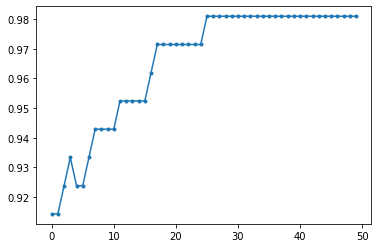

In [ ]:
# посмотрим как изменялась ошибка при обучении
from matplotlib import pyplot as plt
learning_rate=0.1
abc = AdaBoostClassifier(base_estimator=svc, n_estimators=50, learning_rate=learning_rate)
model = abc.fit(X_train, y_train)
score=[ s for s in abc.staged_score(X_train, y_train)]
plt.plot(score,marker='.')
#plt.yscale('log')

Посмотрим на разделяющие поверхности:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



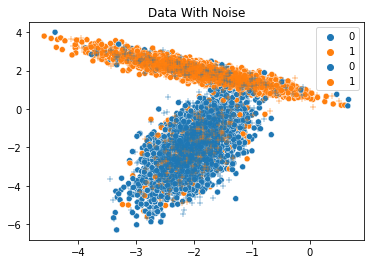

Score= 0.8896969696969697


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



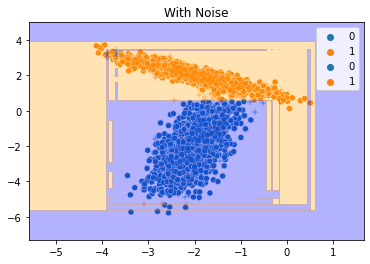

In [ ]:

# функция  для рисования разделяющей поверхности на плоскости
from ML_School.utils import Div_plate
# Div_plate(clf,flip_level) принимает объект-классификатор и уровень шума (ошибок)
# создает двумерные данные, обучает классификатор, рисует разделяющую поверхность 

from sklearn.ensemble import AdaBoostClassifier
# создаем Adaboost классификатор из них
abc = AdaBoostClassifier(n_estimators=100, learning_rate=1)

flip_level=0.2 # уровень шума
Div_plate(abc,flip_level) # рисуем разделяющие поверхности



# Градиентный бустинг. Xgboost
Другая идея бустинга заключается в следующем:
* Пусть мы имеем входы **X** и указания учителя **Y**.
* Обучим первую модель на этих данных, если модель простая,  то обучение будет не очень точным и выход модели будет **F1**, а должны были получить **Y**
* Обучим вторую модель на тех же данных, но для нее указания учителя сделаем **Y-F1**, получим выход **F2**, который тоже может отличаться от желаемого. 
* тогда обучим третью модель, для которой указания учителя будут **Y-F2**, получим выход **F3**.
* будем продолжать обучать все новые и новые модели, пока не надоест или пока не достигнем хорошего обучения или других критериев останова. 
* Результат ансамбля, выход F=F1+F2+F3+...

Если внимательно присмотреться, то величина **(Y - F1)** это градиент по **F1** (со знаком минус) от средневквадратичной ошибки \\(0.5*(Y-F1)^2\\), потому такой бустинг называют ["градиентный бустинг"](https://en.wikipedia.org/wiki/Gradient_boosting), а величины **(Y - F1)** - "остатками" (residuals). 

Для более общего случая, когда функция ошибки не среднеквадратичная, процесс аналогичен:
* Для начальной модели выберем, например, начальную функцию константой, F_0=С, константу можно подобрать оптимальной для функции ошибки.
* в цикле по количеству моделей в ансамбле 
    * посчитаем остаток как минус градиент функции ошибки по выходам F текущего ансамбля
    * создадим и обучим новую модель компенсировать этот остаток (т.е. остаток это указание учителя в обучении), ее выход F_i.
    * Посчитаем новый выход ансамбля как **F_new=F_old+(вес_i) * F_i**  добавив выход новой модели с  некоторым весом, оптимальное значение которого можно найти. 
* в конечном итоге получим выход всего обученного ансамбля.


Для улучшения метода можно обучать новые модели не на том же наборе данных а на *бутстрапе* его, как делали для случайного леса.

Множество реализаций градиентного бустинга существуют. В `sklearn` есть [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)  и 
[`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) для градиентного бустинга деревьев, но наверное одна из наиболее известных это реализация [**xgboost**](https://xgboost.readthedocs.io/en/latest/parameter.html) сделанная в одноименной библиотеке. Хоть это другая библиотека, синтаксис очень похож, в [`XGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgbclassifier#xgboost.XGBClassifier) и [`XGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgbregressor#xgboost.XGBRegressor) реализован бустинг деревьев и линейных моделей. Посмотрим пример.






In [ ]:
import numpy #
import xgboost # подключим библиотеку XGboost
from sklearn.metrics import accuracy_score #
from sklearn.model_selection import train_test_split #
# загрузим данные для классификации
dataset = numpy.loadtxt('ML_School/pima-indians-diabetes.csv', delimiter=",")

# в них последний столбец это класс, остальные - признаки
X = dataset[:,0:8] # помним, что в срезе последний элемент не входит в диапазон 
Y = dataset[:,8] #
# разделяем данные на обучающие и тестовые
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# обучаем градиентный бустинг деревьев (по умолчанию)
model = xgboost.XGBClassifier() # создаем объект
model.fit(X_train, y_train) # обучаем его

# вычисляем выход на тесте
predictions = model.predict(X_test) #

# считаем точность
accuracy = accuracy_score(y_test, predictions) #
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.95%


## Catboost
Стоит упомянуть другую популярную библиотеку [**Catboost**](https://catboost.ai/) (сокр. от categorical boosting, к котикам отношения не имеет) для градиентного бустинга деревьев. Синтаксис в целом похож, но дает настраивать большее число параметров. Особо отличается тем, что позволяет работать с категориальными признаками сразу, без предобработки, библиотека сама сделает все необходимые предобработки. Сейчас посмотрим только примеры, для более глубокого погружения в возможности библиотеки изучайте документацию и примеры самостоятельно. 

Библиотеку надо установить.

In [ ]:
# установка библиотеки
!pip install catboost 

     |████████████████████████████████| 67.3MB 58kB/s 


Обучающие данные заносятся в "пул" (Pool), объект, который будет содержать и выдавать их по мере необходимости, надо указвать индексы категориальных переменных. Классификатор [CatBoostClassifier](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) имеет множество аргументов, из них нам особенно важны:
* iterations - число моделей в ансамбле,
* learning_rate - шаг обучения
* depth - максимальная глубина дерева 

In [ ]:
from catboost import Pool, CatBoostClassifier # подключаем инструмент для оперирования с данными Pool и классификатор
# данные для обучения - одна категориальная и две вещественные переменные
train_data = [["summer", 1924, 44],
              ["summer", 1932, 37],
              ["winter", 1980, 37],
              ["summer", 2012, 204]]
# данные для теста
eval_data = [["winter", 1996, 197],
             ["winter", 1968, 37],
             ["summer", 2002, 77],
             ["summer", 1948, 59]]

cat_features = [0] # номера категориальных переменных

train_label = ["France", "USA", "USA", "UK"] # указания учителя для обучения
eval_label = ["USA", "France", "USA", "UK"] # укзания учителя для теста

# создаем обучающий набор данных 
train_dataset = Pool(data=train_data, # сами данные
                     label=train_label, # указания учителя
                     cat_features=cat_features) # индексы категориальных переменных
# аналогично для тестовых данных
eval_dataset = Pool(data=eval_data, #
                    label=eval_label, #
                    cat_features=cat_features) #

# создаем модель CatBoostClassifier
model = CatBoostClassifier(iterations=10, # число моделей в ансамбле
                           learning_rate=1, # шаг обучения
                           depth=2, # глубина дерева
                           loss_function='MultiClass') # вид функции ошибки
# обучаем ансамбль
model.fit(train_dataset)
# считаем выходы после обучения на тестовых данных
preds_class = model.predict(eval_dataset)
# считаем вероятности классов
preds_proba = model.predict_proba(eval_dataset)
preds_class

0:	learn: 0.9417331	total: 46.3ms	remaining: 416ms
1:	learn: 0.8421839	total: 47.2ms	remaining: 189ms
2:	learn: 0.6597822	total: 47.5ms	remaining: 111ms
3:	learn: 0.6028493	total: 47.8ms	remaining: 71.8ms
4:	learn: 0.4900112	total: 48.1ms	remaining: 48.1ms
5:	learn: 0.4076408	total: 48.5ms	remaining: 32.3ms
6:	learn: 0.3458205	total: 48.8ms	remaining: 20.9ms
7:	learn: 0.2982687	total: 49ms	remaining: 12.3ms
8:	learn: 0.2608927	total: 49.4ms	remaining: 5.48ms
9:	learn: 0.2309514	total: 49.7ms	remaining: 0us


array([['USA'],
       ['USA'],
       ['UK'],
       ['USA']], dtype=object)

# Кроссвалидация
Можно использовать `cv` - скользящий контроль ("кроссвалидация", англ. cross validation), когда обучается множество моделей, обучающие данные разбиваются на N частей (случайно), каждая модель обучается на N-1 своих частях данных, а одна часть данных используется для тестирования этой модели, см. рис. (зеленое - обучающие данные, синее - тестовые)

![img](https://drive.google.com/uc?id=1vKqQNMZ_Xjj-nABJI5I3m-Lm0ctzHjs_)

Библиотека поддерживает интерактивную визуализацию процесса обучения ([Настройки отображения](https://catboost.ai/docs/installation/python-installation-additional-data-visualization-packages.html#python-installation-additional-data-visualization-packages) ) для чего указываем аргумент `plot="True"`

Но в Colab визуализация не работает, разработчики библиотеки ничего не могут сделать. Так что мы не увидим красивых картинок. На своем компьютере вы можете такие картинки увидеть.

In [ ]:
from catboost import Pool, cv # подключам модуль
# данные для обучения и кроссвалидации
cv_data = [["France", 1924, 44],
           ["USA", 1932, 37],
           ["Switzerland", 1928, 25],
           ["Norway", 1952, 30],
           ["Japan", 1972, 35],
           ["Mexico", 1968, 112]]
# указания учителя
labels = [1, 1, 0, 0, 0, 1]

cat_features = [0] # категориальные переменные
# создаем обучающий набор 
cv_dataset = Pool(data=cv_data, # данные
                  label=labels, # указания учителя
                  cat_features=cat_features) # категориальные переменные
# параметры обучения
params = {"iterations": 100, # максимальное число моделей в ансамбле
          "depth": 2, # глубина дерева
          "loss_function": "Logloss", # вид функции ошибки
          "verbose": False} # отображение процесса текстом
# обучение и кроссвалидация
scores = cv(cv_dataset, # данные на которых обучаем
            params, # параметры обучения
            fold_count=2,  # число разбиений данных для кроссвалидации 
            plot="False") # отображение интерактивных графиков


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
scores # посмотрим на результаты тестирования, среднее и разброс (std) для ошибки обучения и теста.

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.689158,0.006109,0.672084,0.006085
1,1,0.678793,0.008546,0.653930,0.008810
2,2,0.679347,0.008143,0.634429,0.014169
3,3,0.679309,0.008943,0.623176,0.008566
4,4,0.659837,0.014349,0.604862,0.013631
...,...,...,...,...,...
95,95,0.440140,0.000115,0.123201,0.033760
96,96,0.440698,0.003598,0.121741,0.033641
97,97,0.442936,0.004940,0.120457,0.033314
98,98,0.442624,0.009889,0.119054,0.033194


Посмотрим на пример регрессии, [оценки стоимости недвижимости](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-dataset). Используем данные load_boston из sklearn. Загрузите эти данные и посмотрите на признаки, сколько их, какой тип?

In [ ]:
import numpy as np
from catboost import CatBoostRegressor, Pool # регрессор

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.datasets import load_boston # данные
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance # для оценки важности признаков


boston=load_boston() # загружаем данные
boston = pd.DataFrame(boston.data, columns=boston.feature_names) # переводим их в pandas

X, y = load_boston(return_X_y=True) # чтобы в ручную не вытаскивать столбцы для указаний учителя, загрузим еще раз в другом формате
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5) # разделим на обучение и тест

boston.head() 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
train_dataset = Pool(X_train, y_train) # создаем пул обучающих данных
test_dataset = Pool(X_test, y_test) # создаем пул тестовых данных

In [ ]:
model = CatBoostRegressor(loss_function='RMSE') # создаем модель для регрессии

Библиотека позволяет проводить подбор гиперпараметров, как в sklearn.

In [ ]:
# задаем "сетку" параметров, варианты, которые нужно проверить
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset) # и обучаем модели со всеми вариантами параметров, будет отобрана наилучшая

Выходные данные были обрезаны до нескольких последних строк (5000).
51:	learn: 6.9643967	test: 6.1703690	best: 6.1703690 (51)	total: 130ms	remaining: 370ms
52:	learn: 6.8280532	test: 6.0206151	best: 6.0206151 (52)	total: 132ms	remaining: 365ms
53:	learn: 6.6867404	test: 5.8736860	best: 5.8736860 (53)	total: 134ms	remaining: 363ms
54:	learn: 6.5599623	test: 5.7452021	best: 5.7452021 (54)	total: 137ms	remaining: 360ms
55:	learn: 6.4233806	test: 5.6137952	best: 5.6137952 (55)	total: 139ms	remaining: 357ms
56:	learn: 6.2980857	test: 5.4898585	best: 5.4898585 (56)	total: 141ms	remaining: 354ms
57:	learn: 6.1844447	test: 5.3765067	best: 5.3765067 (57)	total: 144ms	remaining: 352ms
58:	learn: 6.0535995	test: 5.2625973	best: 5.2625973 (58)	total: 146ms	remaining: 349ms
59:	learn: 5.9506936	test: 5.1712178	best: 5.1712178 (59)	total: 149ms	remaining: 347ms
60:	learn: 5.8350415	test: 5.0654673	best: 5.0654673 (60)	total: 151ms	remaining: 344ms
61:	learn: 5.7322229	test: 4.9681973	best: 4.9681973

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [ ]:
pred = model.predict(X_test) # рассчитываем выход (лучшая модель используется)
rmse = (np.sqrt(mean_squared_error(y_test, pred))) # ошибка rmse
r2 = r2_score(y_test, pred) # точность r2
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 2.83
R2: 0.90


Поскольку модели здесь - деревья, то можно посмотреть на важность признаков. 

Text(0.5, 0, 'CatBoost Feature Importance')

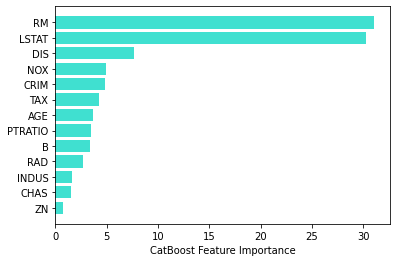

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort() # отсортируем признаки по важности
# и построим график
plt.barh(boston.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

Еще более интересные графики можно построить библиотекой [shap](https://shap.readthedocs.io/en/latest/). Установим ее. Она рассчитывает и показывает величины влияния признаков на результат. 

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 4.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=831597ce3d8ee410f8c301361139a67a5238cf3a5f695724f4047cfcc53fd28e
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


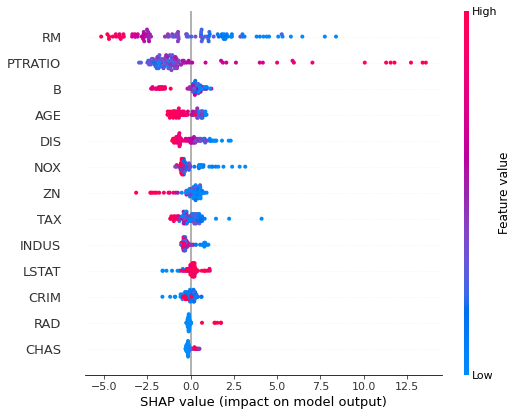

In [ ]:
import shap # подключим библиотеку
explainer = shap.TreeExplainer(model) # "объяснятор" для ансамблей деревьев 
shap_values = explainer.shap_values(X_test) # рассчитываем вклад признаков на тестовых данных
shap.summary_plot(shap_values, X_test, feature_names = boston.columns[sorted_feature_importance]) # строим картинку

По горизонтальной оси показана степень влияния признака на результат, цветом - величина признака. Как малые значения признака RM влияют на результат? 

В градиентном бустинге мы пытаемся скомпенсировать ошибки предыдущих моделей. Библиотека позволяет задать базовое решение (baseline), модель которую будем улучшать деревьями. Она задается выходами (и для обучения и для теста). 

In [ ]:
from sklearn.linear_model import Ridge # модель, которую будем использовать как базовую.
model_ridge=Ridge() # создаем
model_ridge.fit(X_train,y_train) # обучаем
model_ridge_train=model_ridge.predict(X_train) # считаем выходы для обучающих 
model_ridge_test=model_ridge.predict(X_test) # и тестовых данных

train_dataset = Pool(X_train, y_train, baseline=model_ridge_train) # пул для обучающих
test_dataset = Pool(X_test, y_test, baseline=model_ridge_test) #  пул для тестовых данных
model = CatBoostRegressor(loss_function='RMSE') # создаем ансамбль
model.fit(train_dataset,eval_set=test_dataset) # обучаем
pred=model.predict(test_dataset) # считаем выходы
r2_ridge = r2_score(y_test, model_ridge_test) # точночть базовой модели
r2 = r2_score(y_test, pred) # точночть ансамбля
print('Testing performance')
print('R2 Ridge: {:.2f}'.format(r2_ridge))
print('R2 Catboost: {:.2f}'.format(r2))

Learning rate set to 0.038823
0:	learn: 4.7012358	test: 4.6284073	best: 4.6284073 (0)	total: 2.75ms	remaining: 2.74s
1:	learn: 4.6571262	test: 4.6021302	best: 4.6021302 (1)	total: 5.49ms	remaining: 2.74s
2:	learn: 4.6078242	test: 4.5681933	best: 4.5681933 (2)	total: 7.8ms	remaining: 2.59s
3:	learn: 4.5650479	test: 4.5304724	best: 4.5304724 (3)	total: 10.1ms	remaining: 2.52s
4:	learn: 4.5295113	test: 4.5259337	best: 4.5259337 (4)	total: 12.8ms	remaining: 2.55s
5:	learn: 4.5016969	test: 4.5141861	best: 4.5141861 (5)	total: 15.2ms	remaining: 2.52s
6:	learn: 4.4638376	test: 4.4754166	best: 4.4754166 (6)	total: 17.5ms	remaining: 2.48s
7:	learn: 4.4312111	test: 4.4567378	best: 4.4567378 (7)	total: 19.9ms	remaining: 2.46s
8:	learn: 4.3996517	test: 4.4481285	best: 4.4481285 (8)	total: 22.2ms	remaining: 2.44s
9:	learn: 4.3505503	test: 4.4067670	best: 4.4067670 (9)	total: 24.4ms	remaining: 2.42s
10:	learn: 4.3110688	test: 4.3705121	best: 4.3705121 (10)	total: 26.9ms	remaining: 2.42s
11:	learn: 4

### Важное замечание

Никто не гарантирует, что добавление новых моделей в бустинге даст лучший результат, он может и ухудшиться.

Catboost по умолчанию возвращает лучшую из обученных моделей: если вы задали 100 моделей, а после добавления третьей началось ухудшение (на валидации), то в ансамбле останется три модели, остальные будут выброшены.


# Ссылки

Использованы и адаптированы материалы:

https://scikit-learn.org/stable/modules/classes.html?highlight=ensemble#module-sklearn.ensemble 

https://xgboost.readthedocs.io/en/latest/parameter.html

https://catboost.ai/ 

https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329 